In [1]:
import torch
import lightning.pytorch as pl
from skimage.metrics import peak_signal_noise_ratio
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

from src.forward_model.operators import cfa_operator
from src.lightning_classes import UnrolledSystem, DataModule
from src.data_loader import RGBDataset

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CFAS = ['bayer_GRBG', 'quad_bayer', 'sony', 'kodak', 'sparse_3']
TEST_DIR = 'images/test'
BATCH_SIZE = 16

In [3]:
test_dataset = RGBDataset(TEST_DIR, CFAS)
data_module = DataModule(BATCH_SIZE, test_dataset=test_dataset)

version = 'all_4'
model = UnrolledSystem.load_from_checkpoint(f'lightning_logs/{version}/checkpoints/best.ckpt')

trainer = pl.Trainer()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/mullemat/.venv/torch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [4]:
trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 32/32 [00:35<00:00,  0.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss/Test          0.0019174740882590413
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Loss/Test': 0.0019174740882590413}]

In [5]:
def prepare_input(path, cfas):
    x = imread(path) / 255
    inputs = []

    for cfa in cfas:
        op = cfa_operator(cfa, x.shape, [650, 525, 480])
        y = torch.Tensor(op.direct(x))[None]
        mask = torch.Tensor(op.cfa_mask).permute(2, 0, 1)
        inputs.append(torch.cat([y, mask]))

    return x.astype(np.float32), torch.stack(inputs)

In [6]:
path = 'images/test/28083.jpg'
x, input_data = prepare_input(path, CFAS)

model.eval()
with torch.no_grad():
    x_hat_list = np.clip(torch.stack(model(input_data)).permute(1, 0, 3, 4, 2).numpy(force=True), 0, 1)

In [7]:
x = x[2:-2, 2:-2]
x_hat_list = x_hat_list[:, :, 2:-2, 2:-2]

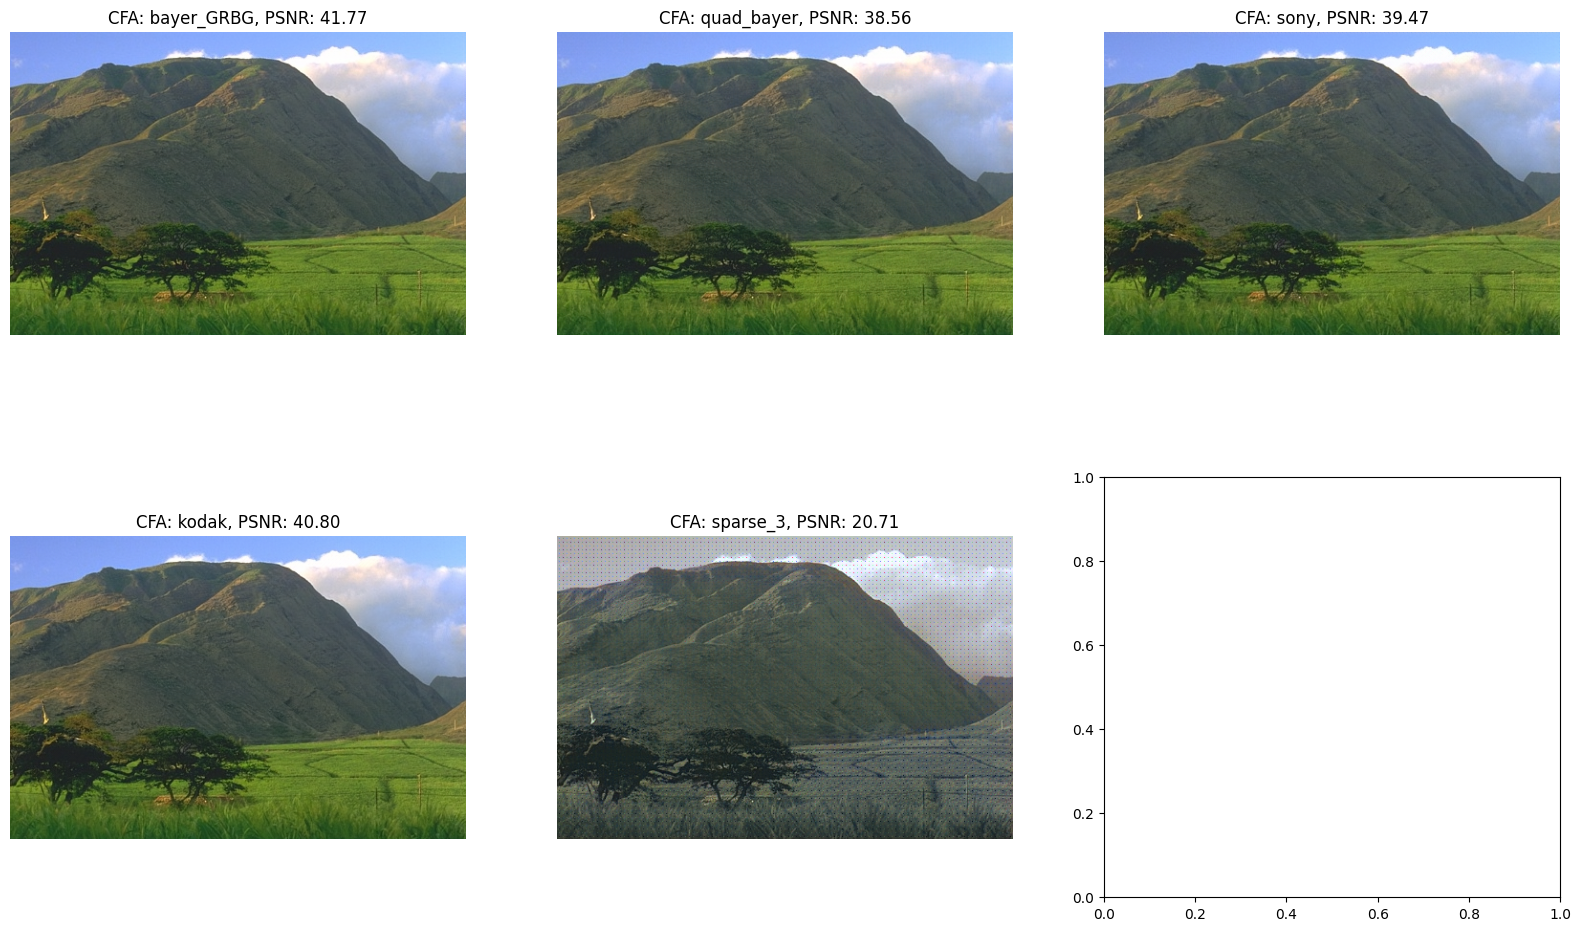

In [8]:
iter = -1
nb_images = len(x_hat_list)
nb_cols = -(-nb_images // 2)

fig, axs = plt.subplots(2, nb_cols, figsize=(20, 12))

for i in range(nb_images):
    axs[i // nb_cols, i % nb_cols].imshow(x_hat_list[i, iter])
    axs[i // nb_cols, i % nb_cols].set_title(f'CFA: {CFAS[i]}, PSNR: {peak_signal_noise_ratio(x, x_hat_list[i, iter]):.2f}')
    axs[i // nb_cols, i % nb_cols].axis('off')

plt.show()

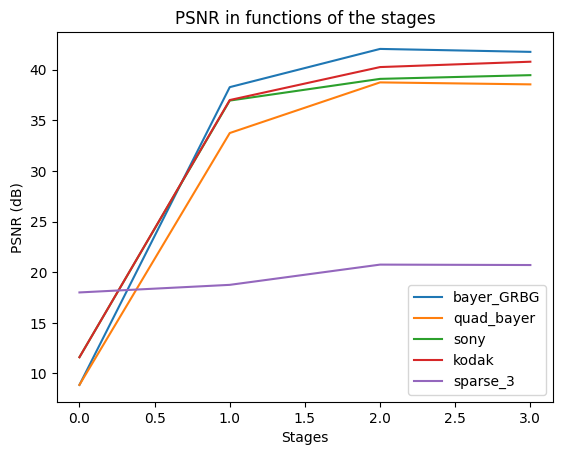

In [9]:
for i in range(len(CFAS)):
    plt.plot([peak_signal_noise_ratio(x, x_hat) for x_hat in x_hat_list[i]], label=CFAS[i])

plt.title('PSNR in functions of the stages')
plt.xlabel('Stages')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()